In [1]:
%load_ext autoreload

In [2]:
import lightning.pytorch as pl
import torch
import os
import dask.dataframe as dd
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import anndata
from matplotlib import rcParams

In [12]:
%autoreload 2
from self_supervision.estimator.cellnet import EstimatorAutoEncoder
from self_supervision.tester.classifier.test import eval_emb_knn
from self_supervision.tester.classifier.test import get_total_correct
from self_supervision.data.datamodules import get_large_ood_dataloader
from self_supervision.data.ood_adata import create_ood_dataloader

In [4]:
DATA_PATH = '/lustre/groups/ml01/workspace/till.richter/merlin_cxg_2023_05_15_sf-log1p'  # this is a shared directory in which the data is stored
MODEL_PATH = '/lustre/groups/ml01/workspace/till.richter/trained_models/'
RESULT_PATH = '/lustre/groups/ml01/workspace/till.richter/ssl_results'
ADATA_PATH = '/lustre/groups/ml01/workspace/till.richter/'
HVG = True

In [5]:
# Set the global font to be Calibri, size 6
rcParams['font.family'] = 'Calibri'
rcParams['font.size'] = 6

# Figure 1
Compare performance on hold out test set on CellNet

kNN classification to include PCA, scVI, Only Pretrained, Supervised, and Self-Supervised

1) Full Transcriptome

In [6]:
# init estim class
estim = EstimatorAutoEncoder(DATA_PATH, hvg=False)

In [7]:
# init datamodule
estim.init_datamodule(batch_size=512) 

In [8]:
estim.trainer = pl.Trainer(logger=[], accelerator='gpu', devices=1)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
# PCA and Random Done as well
model_dirs = [
    ### Supervised Models ###
    
    # MODEL_PATH + '/final_models/classification/No_SSL_run0/default/version_0/checkpoints/best_checkpoint_val.ckpt',  # Done
    # MODEL_PATH + '/final_models/classification/No_SSL_run1/default/version_0/checkpoints/best_checkpoint_val.ckpt',  # Done
    # MODEL_PATH + '/final_models/classification/No_SSL_run2/default/version_0/checkpoints/best_checkpoint_val.ckpt',  # Done
    # MODEL_PATH + '/final_models/classification/No_SSL_run3/default/version_0/checkpoints/best_checkpoint_val.ckpt',  # Done
    # MODEL_PATH + '/final_models/classification/No_SSL_run4/default/version_0/checkpoints/best_checkpoint_val.ckpt',  # Done
    
    ### Only Pretrained Models ###
    
    # Individual Gene Masking
    # MODEL_PATH + '/pretext_models/masking/CN_MLP_50p/default/version_1/checkpoints/best_checkpoint_val.ckpt',  # Done
    
    # Gene Program Masking
    # MODEL_PATH + '/pretext_models/masking/CN_MLP_gene_program_C8_25p/default/version_2/checkpoints/best_checkpoint_val.ckpt',  # Done

    # Gene Program to Gene Program
    # MODEL_PATH + '/pretext_models/masking/CN_MLP_single_gene_program/default/version_1/checkpoints/best_checkpoint_val.ckpt',  # Done
    
    # Gene Program to Transcription Factor    
    # MODEL_PATH + '/pretext_models/masking/CN_MLP_gp_to_tf/default/version_2/checkpoints/best_checkpoint_val.ckpt',  # Done
    
    # Boostrap Your Own Latent (BYOL)
    # MODEL_PATH + '/pretext_models/contrastive/MLP_BYOL_Gaussian_0_001_v4/default/version_0/checkpoints/best_checkpoint_val.ckpt',  # Done
    
    # Barlow Twins
    # MODEL_PATH + '/pretext_models/contrastive/MLP_bt_Gaussian_0_001/best_checkpoint_val.ckpt',  # Done
    
    ### Self-Supervised Models ###
    
    # Individual Gene Masking
    # MODEL_PATH + '/final_models/classification/SSL_CN_MLP_50prun0/default/version_0/checkpoints/best_checkpoint_val.ckpt',  # Done
    # MODEL_PATH + '/final_models/classification/SSL_CN_MLP_50prun1/default/version_1/checkpoints/best_checkpoint_val.ckpt',  # Done
    # MODEL_PATH + '/final_models/classification/SSL_CN_MLP_50prun2/default/version_1/checkpoints/best_checkpoint_val.ckpt',  # Done
    # MODEL_PATH + '/final_models/classification/SSL_CN_MLP_50prun3/default/version_1/checkpoints/best_checkpoint_val.ckpt', Done
    # MODEL_PATH + '/final_models/classification/SSL_CN_MLP_50prun4/default/version_1/checkpoints/best_checkpoint_val.ckpt', Done
    
    # Gene Program Masking
    # MODEL_PATH + '/final_models/classification/SSL_CN_MLP_gene_program_C8_25prun0/default/version_0/checkpoints/best_checkpoint_val.ckpt',  # Done
    MODEL_PATH + '/final_models/classification/SSL_CN_MLP_gene_program_C8_25prun1/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    MODEL_PATH + '/final_models/classification/SSL_CN_MLP_gene_program_C8_25prun2/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    MODEL_PATH + '/final_models/classification/SSL_CN_MLP_gene_program_C8_25prun3/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    MODEL_PATH + '/final_models/classification/SSL_CN_MLP_gene_program_C8_25prun4/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    
    # Gene Program to Gene Program
    # MODEL_PATH + '/final_models/classification/SSL_CN_MLP_single_gene_programrun0/default/version_0/checkpoints/best_checkpoint_val.ckpt',  # Done
    
    # Gene Program to Transcription Factor
    # MODEL_PATH + '/final_models/classification/SSL_CN_MLP_gp_to_tfrun0/default/version_0/checkpoints/best_checkpoint_val.ckpt',  # Done
    
    # Boostrap Your Own Latent (BYOL)
    # MODEL_PATH + '/final_models/classification/SSL_MLP_BYOL_Gaussian_0_001run0/default/version_1/checkpoints/best_checkpoint_val.ckpt',  # Done
    
    # Barlow Twins
    # MODEL_PATH + '/final_models/classification/SSL_contrastive_MLP_bt_Gaussian_0_01run0/default/version_0/checkpoints/best_checkpoint_val.ckpt',  # Done
]

In [ ]:
eval_emb_knn(estim, model_dirs, eval_random=False, eval_pca=False, reference='val')

In [ ]:
model_dir_trick = []
for i in range(len(model_dirs)):
    print('Evaluate model: ', model_dir_trick)
    model_dir_trick = []
    model_dir_trick.append(model_dirs[i])
    eval_emb_knn(estim, model_dir_trick, eval_random=False, eval_pca=False, reference='val')
    torch.cuda.empty_cache()

In [ ]:
# Reading the uploaded CSV file to understand its contents
import pandas as pd

# Load the CSV file into a DataFrame
file_path = os.path.join(RESULT_PATH, 'classification', 'val_clf_report_CellNet_knn.csv')
df = pd.read_csv(file_path)

# Show the first few rows to get an overview of the data
df

# Figure 2

OOD task, where supervised learning may come to its limits

Novel, unseen dataset

**Dissection: Tail of Hippocampus (HiT) - Caudal Hippocampus - CA4-DGC**

- 56,367 cells
- 10x 3' v3
- hippocampal formation
- astrocyte (3761), central nervous system macrophage (1782), endothelial cell (174), ependymal cell (111), ~~fibroblast (86)~~, leukocyte (36), neuron (36588), oligodendrocyte (11875), oligodendrocyte precursor cell (1896), pericyte (39), vascular associated smooth muscle cell (19)

In [ ]:
test_loader_hit = create_ood_dataloader(adata_path=os.path.join(ADATA_PATH, 'tail_of_hippocampus', 'tail_of_hippocampus.h5ad'), data_path=DATA_PATH, batch_size=32)

In [ ]:
model_dirs = [
    ### Supervised Models ###
    
    MODEL_PATH + '/final_models/classification/No_SSL_run0/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    MODEL_PATH + '/final_models/classification/No_SSL_run1/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    MODEL_PATH + '/final_models/classification/No_SSL_run2/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    MODEL_PATH + '/final_models/classification/No_SSL_run3/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    MODEL_PATH + '/final_models/classification/No_SSL_run4/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    
    ### Only Pretrained Models ###
    
    # Individual Gene Masking
    MODEL_PATH + '/pretext_models/masking/CN_MLP_50p/default/version_1/checkpoints/best_checkpoint_val.ckpt',
    MODEL_PATH + '/pretext_models/masking/CN_MLP_50prun1/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    MODEL_PATH + '/pretext_models/masking/CN_MLP_50prun2/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    MODEL_PATH + '/pretext_models/masking/CN_MLP_50prun3/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    MODEL_PATH + '/pretext_models/masking/CN_MLP_50prun4/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    
    ### Self-Supervised Models ###
    
    # Individual Gene Masking
    MODEL_PATH + '/final_models/classification/SSL_CN_MLP_50prun0/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    MODEL_PATH + '/final_models/classification/SSL_CN_MLP_50prun1/default/version_1/checkpoints/best_checkpoint_val.ckpt',
    MODEL_PATH + '/final_models/classification/SSL_CN_MLP_50prun2/default/version_1/checkpoints/best_checkpoint_val.ckpt',
    MODEL_PATH + '/final_models/classification/SSL_CN_MLP_50prun3/default/version_1/checkpoints/best_checkpoint_val.ckpt',
    MODEL_PATH + '/final_models/classification/SSL_CN_MLP_50prun4/default/version_1/checkpoints/best_checkpoint_val.ckpt',
]

In [ ]:
# init estim class
estim = EstimatorAutoEncoder(DATA_PATH, hvg=False)

In [ ]:
# init datamodule
estim.init_datamodule(batch_size=1024) 

In [ ]:
eval_emb_knn(estim, model_dirs=model_dirs, setting='OOD_HiT', test_dataloader=test_loader_hit, eval_random=True, eval_pca=False, reference='val')

In [ ]:
# Reading the uploaded CSV file to understand its contents
import pandas as pd

# Load the CSV file into a DataFrame
file_path = os.path.join(RESULT_PATH, 'classification', 'val_clf_report_OOD_HiT_knn.csv')
df = pd.read_csv(file_path)

# Remove duplicates
df = df.drop_duplicates()

# Show the first few rows to get an overview of the data
df

**All non-neuronal cells**

- 888,263 cells
- 10x 3' v3
- Bergmann glial cell (8041), astrocyte (155025), central nervous system macrophage (91383), ~~choroid plexus epithelial cell (7689)~~, endothelial cell (5165), ependymal cell (5882), ~~fibroblast (9156)~~, oligodendrocyte (494966), oligodendrocyte precursor cell (105734), pericyte (3693), vascular associated smooth muscle cell (1074)

In [ ]:
ood_set = 'non_neuronal'  # non_neuronal
ROOT_PATH = '/lustre/groups/ml01/workspace/till.richter/'

In [ ]:
# Load OOD data
x_file_path = os.path.join(ROOT_PATH, ood_set, 'processed_tensor_x.hdf5')
y_file_path = os.path.join(ROOT_PATH, ood_set, 'processed_tensor_y.hdf5')
ood_dataloader = get_large_ood_dataloader(x_file_path, y_file_path, batch_size=1024)

In [ ]:
model_dirs = [
    ### Supervised Models ###
    
    MODEL_PATH + '/final_models/classification/No_SSL_run0/default/version_0/checkpoints/best_checkpoint_val.ckpt',  # Done
    MODEL_PATH + '/final_models/classification/No_SSL_run1/default/version_0/checkpoints/best_checkpoint_val.ckpt',  # Done
    MODEL_PATH + '/final_models/classification/No_SSL_run2/default/version_0/checkpoints/best_checkpoint_val.ckpt',  # Done
    MODEL_PATH + '/final_models/classification/No_SSL_run3/default/version_0/checkpoints/best_checkpoint_val.ckpt',  # Done
    MODEL_PATH + '/final_models/classification/No_SSL_run4/default/version_0/checkpoints/best_checkpoint_val.ckpt',  # Done
    
    ### Only Pretrained Models ###
    
    # Individual Gene Masking
    MODEL_PATH + '/pretext_models/masking/CN_MLP_50p/default/version_1/checkpoints/best_checkpoint_val.ckpt',  # Done
    MODEL_PATH + '/pretext_models/masking/CN_MLP_50prun1/default/version_0/checkpoints/best_checkpoint_val.ckpt',  # Done
    MODEL_PATH + '/pretext_models/masking/CN_MLP_50prun2/default/version_0/checkpoints/best_checkpoint_val.ckpt',  # Done
    MODEL_PATH + '/pretext_models/masking/CN_MLP_50prun3/default/version_0/checkpoints/best_checkpoint_val.ckpt',  # Done
    MODEL_PATH + '/pretext_models/masking/CN_MLP_50prun4/default/version_0/checkpoints/best_checkpoint_val.ckpt',  # Done
    
    ### Self-Supervised Models ###
    
    # Individual Gene Masking
    MODEL_PATH + '/final_models/classification/SSL_CN_MLP_50prun0/default/version_0/checkpoints/best_checkpoint_val.ckpt',  # Done
    MODEL_PATH + '/final_models/classification/SSL_CN_MLP_50prun1/default/version_1/checkpoints/best_checkpoint_val.ckpt',  # Done
    MODEL_PATH + '/final_models/classification/SSL_CN_MLP_50prun2/default/version_1/checkpoints/best_checkpoint_val.ckpt',  # Done
    MODEL_PATH + '/final_models/classification/SSL_CN_MLP_50prun3/default/version_1/checkpoints/best_checkpoint_val.ckpt',  # Done
    MODEL_PATH + '/final_models/classification/SSL_CN_MLP_50prun4/default/version_1/checkpoints/best_checkpoint_val.ckpt',  # Done
]

In [ ]:
# # init estim class
estim = EstimatorAutoEncoder(DATA_PATH, hvg=False)

In [ ]:
# init datamodule
estim.init_datamodule(batch_size=1024) 

In [ ]:
eval_emb_knn(estim, model_dirs=model_dirs, setting='OOD_nn', test_dataloader=ood_dataloader, eval_random=True, eval_pca=False, reference='val')

In [ ]:
# Reading the uploaded CSV file to understand its contents
import pandas as pd

# Load the CSV file into a DataFrame
file_path = os.path.join(RESULT_PATH, 'classification', 'val_clf_report_OOD_nn_knn.csv')
df = pd.read_csv(file_path)
df = df.drop_duplicates()

# Show the first few rows to get an overview of the data
df

### **Human: Great apes study**

- 156,285 cells
- 10x 3' v3 Smart-seq v4
- L2/3-6 intratelencephalic projecting glutamatergic cortical neuron (85276), L5 something not included (392), L6b glutamatergic cortical neuron (3415), astrocyte of the cerebral cortex (3047), caudial ganglio... not included (844), cerebral cortex endothelial cell (168), chandelier pval (728), cortocothalami... (3118), lamp5 GABAeric... (6416), microglial cell (1263), near-projecting ... (3461), oligodendrocyte (7876), oligodendrocyte precursor cell (2392), pvalb GABAergic (11778), sncg GABAergic (2025), sst GABAergic cortical interneuron (13593), vascular leptomeningeal cell (276), vip GABAergic cortical interneuron (10219)

In [9]:
test_loader_apes = create_ood_dataloader(adata_path=os.path.join(ADATA_PATH, 'great_apes', 'great_apes.h5ad'), data_path=DATA_PATH, batch_size=32)

Loaded tensor_x and tensor_y from disk.
Created DataLoader.


In [10]:
model_dirs = [
    ### Supervised Models ###
    
    MODEL_PATH + '/final_models/classification/No_SSL_run0/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    MODEL_PATH + '/final_models/classification/No_SSL_run1/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    MODEL_PATH + '/final_models/classification/No_SSL_run2/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    MODEL_PATH + '/final_models/classification/No_SSL_run3/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    MODEL_PATH + '/final_models/classification/No_SSL_run4/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    
    ### Only Pretrained Models ###
    
    # Individual Gene Masking
    MODEL_PATH + '/pretext_models/masking/CN_MLP_50p/default/version_1/checkpoints/best_checkpoint_val.ckpt',
    MODEL_PATH + '/pretext_models/masking/CN_MLP_50prun1/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    MODEL_PATH + '/pretext_models/masking/CN_MLP_50prun2/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    MODEL_PATH + '/pretext_models/masking/CN_MLP_50prun3/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    MODEL_PATH + '/pretext_models/masking/CN_MLP_50prun4/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    
    ### Self-Supervised Models ###
    
    # Individual Gene Masking
    MODEL_PATH + '/final_models/classification/SSL_CN_MLP_50prun0/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    MODEL_PATH + '/final_models/classification/SSL_CN_MLP_50prun1/default/version_1/checkpoints/best_checkpoint_val.ckpt',
    MODEL_PATH + '/final_models/classification/SSL_CN_MLP_50prun2/default/version_1/checkpoints/best_checkpoint_val.ckpt',
    MODEL_PATH + '/final_models/classification/SSL_CN_MLP_50prun3/default/version_1/checkpoints/best_checkpoint_val.ckpt',
    MODEL_PATH + '/final_models/classification/SSL_CN_MLP_50prun4/default/version_1/checkpoints/best_checkpoint_val.ckpt',
]

In [11]:
# init estim class
estim = EstimatorAutoEncoder(DATA_PATH, hvg=False)

In [12]:
# init datamodule
estim.init_datamodule(batch_size=1024) 

In [ ]:
eval_emb_knn(estim, model_dirs=model_dirs, setting='OOD_Great_Apes', test_dataloader=test_loader_apes, eval_random=True, eval_pca=False, reference='val')

In [ ]:
# Reading the uploaded CSV file to understand its contents
import pandas as pd

# Load the CSV file into a DataFrame
file_path = os.path.join(RESULT_PATH, 'classification', 'val_clf_report_OOD_Great_Apes_knn.csv')
df = pd.read_csv(file_path)

# Remove duplicates
df = df.drop_duplicates()

# Show the first few rows to get an overview of the data
df

# Figure 3

Does pretraining on a large, auxiliary dataset improve performance on a specific, known dataset to be classified?

## 1. HLCA

In [23]:
# TO DO: DOUBLE CHECK WITH NEW RUNS FOR HLCA

model_dirs = [
    # Individual Gene Masking
    MODEL_PATH + '/pretext_models/masking/CN_MLP_50p/default/version_1/checkpoints/best_checkpoint_val.ckpt',  # Done
    MODEL_PATH + '/pretext_models/masking/CN_MLP_50prun1/default/version_0/checkpoints/best_checkpoint_val.ckpt',  # Done
    MODEL_PATH + '/pretext_models/masking/CN_MLP_50prun2/default/version_0/checkpoints/best_checkpoint_val.ckpt',  # Done
    MODEL_PATH + '/pretext_models/masking/CN_MLP_50prun3/default/version_0/checkpoints/best_checkpoint_val.ckpt',  # Done
    MODEL_PATH + '/pretext_models/masking/CN_MLP_50prun4/default/version_0/checkpoints/best_checkpoint_val.ckpt',  # Done
    
    # Gene Program Masking
    MODEL_PATH + '/pretext_models/masking/CN_MLP_gene_program_C8_25p/default/version_2/checkpoints/best_checkpoint_val.ckpt',
    MODEL_PATH + '/pretext_models/masking/CN_MLP_gene_program_C8_25p/default/version_0/checkpoints/best_checkpoint_val.ckpt', # To Do
    MODEL_PATH + '/pretext_models/masking/CN_MLP_gene_program_C8_25p/default/version_0/checkpoints/best_checkpoint_val.ckpt', # To Do
    MODEL_PATH + '/pretext_models/masking/CN_MLP_gene_program_C8_25p/default/version_0/checkpoints/best_checkpoint_val.ckpt', # To Do
    MODEL_PATH + '/pretext_models/masking/CN_MLP_gene_program_C8_25p/default/version_0/checkpoints/best_checkpoint_val.ckpt', # To Do
    
    
    ### Supervised Models ###
    
    MODEL_PATH + '/final_models/classification/No_SSL_new_run0_HLCA/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    MODEL_PATH + '/final_models/classification/No_SSL_new_run1_HLCA/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    MODEL_PATH + '/final_models/classification/No_SSL_new_run2_HLCA/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    MODEL_PATH + '/final_models/classification/No_SSL_new_run3_HLCA/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    MODEL_PATH + '/final_models/classification/No_SSL_new_run4_HLCA/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    
    ### Self-Supervised Models ###
    
    # Individual Gene Masking
    MODEL_PATH + '/final_models/classification/SSL_CN_MLP_50pnew_run0_HLCA/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    MODEL_PATH + '/final_models/classification/SSL_CN_MLP_50prun1_HLCA/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    MODEL_PATH + '/final_models/classification/SSL_CN_MLP_50prun2_HLCA/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    MODEL_PATH + '/final_models/classification/SSL_CN_MLP_50prun3_HLCA/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    MODEL_PATH + '/final_models/classification/SSL_CN_MLP_50prun4_HLCA/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    
    
    # Gene Program Masking
    MODEL_PATH + '//final_models/classification/SSL_CN_MLP_gene_program_C8_25prun0_HLCA/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    MODEL_PATH + '//final_models/classification/SSL_CN_MLP_gene_program_C8_25prun1_HLCA/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    MODEL_PATH + '//final_models/classification/SSL_CN_MLP_gene_program_C8_25prun2_HLCA/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    MODEL_PATH + '//final_models/classification/SSL_CN_MLP_gene_program_C8_25prun3_HLCA/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    MODEL_PATH + '//final_models/classification/SSL_CN_MLP_gene_program_C8_25prun4_HLCA/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    
    # Gene Program to Gene Program
    
    # Gene Program to Transcription Factor
    
    # Boostrap Your Own Latent (BYOL)
    # MODEL_PATH + '/final_models/classification/SSL_MLP_BYOL_Gaussian_0_001run0_HLCA/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    
    # Barlow Twins
    # MODEL_PATH + '/final_models/classification/SSL_contrastive_MLP_bt_Gaussian_0_01run0_HLCA/default/version_0/checkpoints/best_checkpoint_val.ckpt',
]

In [24]:
eval_emb_knn(estim, model_dirs, setting='hlca', eval_random=True, eval_pca=False, reference='val')

Am in hlca setting, have 117517 test and 117541 val labels left
Loaded train labels:  (15240192,) val labels:  (117541,) test labels:  (117517,)
Evaluating /lustre/groups/ml01/workspace/till.richter/trained_models//pretext_models/masking/CN_MLP_50p/default/version_1/checkpoints/best_checkpoint_val.ckpt
Get index for pretrained
Loading model with supervised_subset:  148
Initializing model...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


dict keys:  odict_keys(['class_weights', 'child_lookup', 'classifier.0.weight', 'classifier.0.bias', 'classifier.3.weight', 'classifier.3.bias', 'classifier.6.weight', 'classifier.6.bias', 'classifier.9.weight', 'classifier.9.bias', 'classifier.12.weight', 'classifier.12.bias', 'classifier.15.weight', 'classifier.15.bias']) odict_keys(['encoder.0.weight', 'encoder.0.bias', 'encoder.3.weight', 'encoder.3.bias', 'encoder.6.weight', 'encoder.6.bias', 'encoder.9.weight', 'encoder.9.bias', 'encoder.12.weight', 'encoder.12.bias', 'decoder.0.0.weight', 'decoder.0.0.bias', 'decoder.0.3.weight', 'decoder.0.3.bias', 'decoder.0.6.weight', 'decoder.0.6.bias', 'decoder.0.9.weight', 'decoder.0.9.bias', 'decoder.0.12.weight', 'decoder.0.12.bias'])
Did not find match for class_weights in pretrained_dict. Initializing randomly.
Did not find match for child_lookup in pretrained_dict. Initializing randomly.
Weight transfer: Matched classifier.0.weight
Weight transfer: Matched classifier.0.bias
Weight tra

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


dict keys:  odict_keys(['class_weights', 'child_lookup', 'classifier.0.weight', 'classifier.0.bias', 'classifier.3.weight', 'classifier.3.bias', 'classifier.6.weight', 'classifier.6.bias', 'classifier.9.weight', 'classifier.9.bias', 'classifier.12.weight', 'classifier.12.bias', 'classifier.15.weight', 'classifier.15.bias']) odict_keys(['encoder.0.weight', 'encoder.0.bias', 'encoder.3.weight', 'encoder.3.bias', 'encoder.6.weight', 'encoder.6.bias', 'encoder.9.weight', 'encoder.9.bias', 'encoder.12.weight', 'encoder.12.bias', 'decoder.0.0.weight', 'decoder.0.0.bias', 'decoder.0.3.weight', 'decoder.0.3.bias', 'decoder.0.6.weight', 'decoder.0.6.bias', 'decoder.0.9.weight', 'decoder.0.9.bias', 'decoder.0.12.weight', 'decoder.0.12.bias'])
Did not find match for class_weights in pretrained_dict. Initializing randomly.
Did not find match for child_lookup in pretrained_dict. Initializing randomly.
Weight transfer: Matched classifier.0.weight
Weight transfer: Matched classifier.0.bias
Weight tra

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-PCIE-40GB MIG 3g.20gb') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-6d67b200-09a5-5833-88a5-d79c3a331619]


Predicting: 0it [00:00, ?it/s]

Saved val embeddings to disk at  /lustre/groups/ml01/workspace/till.richter/ssl_results/classification/embeddings/val_emb_CN_MLP_50prun2_Only Pretrained_hlca.npy
Loaded test embeddings from disk at  /lustre/groups/ml01/workspace/till.richter/ssl_results/classification/embeddings/test_emb_CN_MLP_50prun2_Only Pretrained_hlca.npy
Loaded reference embeddings:  (117541, 64) test embeddings:  (117517, 64)
Start kNN...Evaluating /lustre/groups/ml01/workspace/till.richter/trained_models//pretext_models/masking/CN_MLP_50prun3/default/version_0/checkpoints/best_checkpoint_val.ckpt
Get index for pretrained
Loading model with supervised_subset:  148

dict keys:  odict_keys(['class_weights', 'child_lookup', 'classifier.0.weight', 'classifier.0.bias', 'classifier.3.weight', 'classifier.3.bias', 'classifier.6.weight', 'classifier.6.bias', 'classifier.9.weight', 'classifier.9.bias', 'classifier.12.weight', 'classifier.12.bias', 'classifier.15.weight', 'classifier.15.bias']) odict_keys(['encoder.0.weig

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Loaded val embeddings from disk at  /lustre/groups/ml01/workspace/till.richter/ssl_results/classification/embeddings/val_emb_CN_MLP_50prun3_Only Pretrained_hlca.npy
Loaded test embeddings from disk at  /lustre/groups/ml01/workspace/till.richter/ssl_results/classification/embeddings/test_emb_CN_MLP_50prun3_Only Pretrained_hlca.npy
Loaded reference embeddings:  (117541, 64) test embeddings:  (117517, 64)
Evaluating /lustre/groups/ml01/workspace/till.richter/trained_models//pretext_models/masking/CN_MLP_50prun4/default/version_0/checkpoints/best_checkpoint_val.ckpt
Get index for pretrained
Loading model with supervised_subset:  148
Start kNN...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


dict keys:  odict_keys(['class_weights', 'child_lookup', 'classifier.0.weight', 'classifier.0.bias', 'classifier.3.weight', 'classifier.3.bias', 'classifier.6.weight', 'classifier.6.bias', 'classifier.9.weight', 'classifier.9.bias', 'classifier.12.weight', 'classifier.12.bias', 'classifier.15.weight', 'classifier.15.bias']) odict_keys(['encoder.0.weight', 'encoder.0.bias', 'encoder.3.weight', 'encoder.3.bias', 'encoder.6.weight', 'encoder.6.bias', 'encoder.9.weight', 'encoder.9.bias', 'encoder.12.weight', 'encoder.12.bias', 'decoder.0.0.weight', 'decoder.0.0.bias', 'decoder.0.3.weight', 'decoder.0.3.bias', 'decoder.0.6.weight', 'decoder.0.6.bias', 'decoder.0.9.weight', 'decoder.0.9.bias', 'decoder.0.12.weight', 'decoder.0.12.bias'])
Did not find match for class_weights in pretrained_dict. Initializing randomly.
Did not find match for child_lookup in pretrained_dict. Initializing randomly.
Weight transfer: Matched classifier.0.weight
Weight transfer: Matched classifier.0.bias
Weight tra

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


dict keys:  odict_keys(['class_weights', 'child_lookup', 'classifier.0.weight', 'classifier.0.bias', 'classifier.3.weight', 'classifier.3.bias', 'classifier.6.weight', 'classifier.6.bias', 'classifier.9.weight', 'classifier.9.bias', 'classifier.12.weight', 'classifier.12.bias', 'classifier.15.weight', 'classifier.15.bias']) odict_keys(['encoder.0.weight', 'encoder.0.bias', 'encoder.3.weight', 'encoder.3.bias', 'encoder.6.weight', 'encoder.6.bias', 'encoder.9.weight', 'encoder.9.bias', 'encoder.12.weight', 'encoder.12.bias', 'decoder.0.0.weight', 'decoder.0.0.bias', 'decoder.0.3.weight', 'decoder.0.3.bias', 'decoder.0.6.weight', 'decoder.0.6.bias', 'decoder.0.9.weight', 'decoder.0.9.bias', 'decoder.0.12.weight', 'decoder.0.12.bias'])
Did not find match for class_weights in pretrained_dict. Initializing randomly.
Did not find match for child_lookup in pretrained_dict. Initializing randomly.
Weight transfer: Matched classifier.0.weight
Weight transfer: Matched classifier.0.bias
Weight tra

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


dict keys:  odict_keys(['class_weights', 'child_lookup', 'classifier.0.weight', 'classifier.0.bias', 'classifier.3.weight', 'classifier.3.bias', 'classifier.6.weight', 'classifier.6.bias', 'classifier.9.weight', 'classifier.9.bias', 'classifier.12.weight', 'classifier.12.bias', 'classifier.15.weight', 'classifier.15.bias']) odict_keys(['encoder.0.weight', 'encoder.0.bias', 'encoder.3.weight', 'encoder.3.bias', 'encoder.6.weight', 'encoder.6.bias', 'encoder.9.weight', 'encoder.9.bias', 'encoder.12.weight', 'encoder.12.bias', 'decoder.0.0.weight', 'decoder.0.0.bias', 'decoder.0.3.weight', 'decoder.0.3.bias', 'decoder.0.6.weight', 'decoder.0.6.bias', 'decoder.0.9.weight', 'decoder.0.9.bias', 'decoder.0.12.weight', 'decoder.0.12.bias'])
Did not find match for class_weights in pretrained_dict. Initializing randomly.
Did not find match for child_lookup in pretrained_dict. Initializing randomly.
Weight transfer: Matched classifier.0.weight
Weight transfer: Matched classifier.0.bias
Weight tra

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


dict keys:  odict_keys(['class_weights', 'child_lookup', 'classifier.0.weight', 'classifier.0.bias', 'classifier.3.weight', 'classifier.3.bias', 'classifier.6.weight', 'classifier.6.bias', 'classifier.9.weight', 'classifier.9.bias', 'classifier.12.weight', 'classifier.12.bias', 'classifier.15.weight', 'classifier.15.bias']) odict_keys(['encoder.0.weight', 'encoder.0.bias', 'encoder.3.weight', 'encoder.3.bias', 'encoder.6.weight', 'encoder.6.bias', 'encoder.9.weight', 'encoder.9.bias', 'encoder.12.weight', 'encoder.12.bias', 'decoder.0.0.weight', 'decoder.0.0.bias', 'decoder.0.3.weight', 'decoder.0.3.bias', 'decoder.0.6.weight', 'decoder.0.6.bias', 'decoder.0.9.weight', 'decoder.0.9.bias', 'decoder.0.12.weight', 'decoder.0.12.bias'])
Did not find match for class_weights in pretrained_dict. Initializing randomly.
Did not find match for child_lookup in pretrained_dict. Initializing randomly.
Weight transfer: Matched classifier.0.weight
Weight transfer: Matched classifier.0.bias
Weight tra

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Loaded val embeddings from disk at  /lustre/groups/ml01/workspace/till.richter/ssl_results/classification/embeddings/val_emb_CN_MLP_gene_program_C8_25p_Only Pretrained_hlca.npy
Loaded test embeddings from disk at  /lustre/groups/ml01/workspace/till.richter/ssl_results/classification/embeddings/test_emb_CN_MLP_gene_program_C8_25p_Only Pretrained_hlca.npy
Loaded reference embeddings:  (117541, 64) test embeddings:  (117517, 64)
Start kNN...
Evaluating /lustre/groups/ml01/workspace/till.richter/trained_models//pretext_models/masking/CN_MLP_gene_program_C8_25p/default/version_0/checkpoints/best_checkpoint_val.ckpt
Get index for pretrained
Loading model with supervised_subset:  148
dict keys:  odict_keys(['class_weights', 'child_lookup', 'classifier.0.weight', 'classifier.0.bias', 'classifier.3.weight', 'classifier.3.bias', 'classifier.6.weight', 'classifier.6.bias', 'classifier.9.weight', 'classifier.9.bias', 'classifier.12.weight', 'classifier.12.bias', 'classifier.15.weight', 'classifier

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Loaded val embeddings from disk at  /lustre/groups/ml01/workspace/till.richter/ssl_results/classification/embeddings/val_emb_CN_MLP_gene_program_C8_25p_Only Pretrained_hlca.npy
Loaded test embeddings from disk at  /lustre/groups/ml01/workspace/till.richter/ssl_results/classification/embeddings/test_emb_CN_MLP_gene_program_C8_25p_Only Pretrained_hlca.npy
Loaded reference embeddings:  (117541, 64) test embeddings:  (117517, 64)
Start kNN...
Evaluating /lustre/groups/ml01/workspace/till.richter/trained_models//final_models/classification/No_SSL_new_run0_HLCA/default/version_0/checkpoints/best_checkpoint_val.ckpt
Get index for no ssl
Skipping No_SSL_new_run0_HLCA_No SSL
Evaluating /lustre/groups/ml01/workspace/till.richter/trained_models//final_models/classification/No_SSL_new_run1_HLCA/default/version_0/checkpoints/best_checkpoint_val.ckpt
Get index for no ssl
Skipping No_SSL_new_run1_HLCA_No SSL
Evaluating /lustre/groups/ml01/workspace/till.richter/trained_models//final_models/classifica

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Loaded val embeddings from disk at  /lustre/groups/ml01/workspace/till.richter/ssl_results/classification/embeddings/val_emb_SSL_CN_MLP_gene_program_C8_25prun0_HLCA_SSL_hlca.npy


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-6d67b200-09a5-5833-88a5-d79c3a331619]


Predicting: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

Saved test embeddings to disk at  /lustre/groups/ml01/workspace/till.richter/ssl_results/classification/embeddings/test_emb_SSL_CN_MLP_gene_program_C8_25prun1_HLCA_SSL_hlca.npy
Loaded reference embeddings:  (117541, 64) test embeddings:  (117517, 64)
Start kNN...
Evaluating /lustre/groups/ml01/workspace/till.richter/trained_models///final_models/classification/SSL_CN_MLP_gene_program_C8_25prun2_HLCA/default/version_0/checkpoints/best_checkpoint_val.ckpt
Get index for ssl
Loading model with supervised_subset:  148


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-6d67b200-09a5-5833-88a5-d79c3a331619]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-6d67b200-09a5-5833-88a5-d79c3a331619]


Saved val embeddings to disk at  /lustre/groups/ml01/workspace/till.richter/ssl_results/classification/embeddings/val_emb_SSL_CN_MLP_gene_program_C8_25prun2_HLCA_SSL_hlca.npy


Predicting: 0it [00:00, ?it/s]

Saved test embeddings to disk at  /lustre/groups/ml01/workspace/till.richter/ssl_results/classification/embeddings/test_emb_SSL_CN_MLP_gene_program_C8_25prun2_HLCA_SSL_hlca.npy
Loaded reference embeddings:  (117541, 64) test embeddings:  (117517, 64)
Start kNN...
Evaluating /lustre/groups/ml01/workspace/till.richter/trained_models///final_models/classification/SSL_CN_MLP_gene_program_C8_25prun3_HLCA/default/version_0/checkpoints/best_checkpoint_val.ckpt
Get index for ssl
Loading model with supervised_subset:  148


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-6d67b200-09a5-5833-88a5-d79c3a331619]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-6d67b200-09a5-5833-88a5-d79c3a331619]


Saved val embeddings to disk at  /lustre/groups/ml01/workspace/till.richter/ssl_results/classification/embeddings/val_emb_SSL_CN_MLP_gene_program_C8_25prun3_HLCA_SSL_hlca.npy


Predicting: 0it [00:00, ?it/s]

Saved test embeddings to disk at  /lustre/groups/ml01/workspace/till.richter/ssl_results/classification/embeddings/test_emb_SSL_CN_MLP_gene_program_C8_25prun3_HLCA_SSL_hlca.npy
Loaded reference embeddings:  (117541, 64) test embeddings:  (117517, 64)
Start kNN...
Evaluating /lustre/groups/ml01/workspace/till.richter/trained_models///final_models/classification/SSL_CN_MLP_gene_program_C8_25prun4_HLCA/default/version_0/checkpoints/best_checkpoint_val.ckpt
Get index for ssl
Loading model with supervised_subset:  148


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-6d67b200-09a5-5833-88a5-d79c3a331619]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-6d67b200-09a5-5833-88a5-d79c3a331619]


Saved val embeddings to disk at  /lustre/groups/ml01/workspace/till.richter/ssl_results/classification/embeddings/val_emb_SSL_CN_MLP_gene_program_C8_25prun4_HLCA_SSL_hlca.npy


Predicting: 0it [00:00, ?it/s]

Saved test embeddings to disk at  /lustre/groups/ml01/workspace/till.richter/ssl_results/classification/embeddings/test_emb_SSL_CN_MLP_gene_program_C8_25prun4_HLCA_SSL_hlca.npy
Loaded reference embeddings:  (117541, 64) test embeddings:  (117517, 64)
Start kNN...
Get index for pretrained
Saved  CN_MLP_gene_program_C8_25p_Only Pretrained  to  /lustre/groups/ml01/workspace/till.richter/ssl_results/classification/val_clf_report_hlca_knn.csv
Done evaluating /lustre/groups/ml01/workspace/till.richter/trained_models//pretext_models/masking/CN_MLP_gene_program_C8_25p/default/version_0/checkpoints/best_checkpoint_val.ckpt
Get index for pretrained
Saved  CN_MLP_50prun1_Only Pretrained  to  /lustre/groups/ml01/workspace/till.richter/ssl_results/classification/val_clf_report_hlca_knn.csv
Done evaluating /lustre/groups/ml01/workspace/till.richter/trained_models//pretext_models/masking/CN_MLP_50prun1/default/version_0/checkpoints/best_checkpoint_val.ckpt
Get index for pretrained
Saved  CN_MLP_gene_

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-6d67b200-09a5-5833-88a5-d79c3a331619]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-6d67b200-09a5-5833-88a5-d79c3a331619]


Saved reference embeddings to disk at  /lustre/groups/ml01/workspace/till.richter/ssl_results/classification/embeddings/val_emb_Randomhlca.npy


Predicting: 0it [00:00, ?it/s]

Saved test embeddings to disk at  /lustre/groups/ml01/workspace/till.richter/ssl_results/classification/embeddings/test_emb_Randomhlca.npy


AssertionError: Reference embeddings and labels do not match in shape. Your shape of the reference embeddings is: (3500032, 64) and the shape of the reference labels is: (117541,)

In [ ]:
# Reading the uploaded CSV file to understand its contents
import pandas as pd

# Load the CSV file into a DataFrame
file_path = os.path.join(RESULT_PATH, 'classification', 'val_clf_report_hlca_knn.csv')
df = pd.read_csv(file_path)

# Remove duplicates
df = df.drop_duplicates()

# Show the first few rows to get an overview of the data
df

Histogram

In [8]:
%autoreload 2
from self_supervision.tester.classifier.kNN_new import eval_emb_knn_per_class

In [9]:
supervised_model = MODEL_PATH + '/final_models/classification/No_SSL_new_run1_HLCA/default/version_0/checkpoints/best_checkpoint_val.ckpt'
ssl_model = MODEL_PATH + '/final_models/classification/SSL_CN_MLP_50prun4_HLCA/default/version_0/checkpoints/best_checkpoint_val.ckpt'

In [12]:
df_supervised = eval_emb_knn_per_class(estim, [supervised_model], setting='hlca', reference='val')
df_ssl = eval_emb_knn_per_class(estim, [ssl_model], setting='hlca', reference='val')

Am in hlca setting, have 117517 test and 117541 val labels left
Loaded train labels:  (15240192,) val labels:  (117541,) test labels:  (117517,)
Evaluating /lustre/groups/ml01/workspace/till.richter/trained_models//final_models/classification/No_SSL_new_run1_HLCA/default/version_0/checkpoints/best_checkpoint_val.ckpt
Get index for no ssl
Loading model with supervised_subset:  148


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Loaded val embeddings from disk at  /lustre/groups/ml01/workspace/till.richter/ssl_results/classification/embeddings/val_emb_No_SSL_new_run1_HLCA_No SSL.npy
Loaded test embeddings from disk.
Loaded reference embeddings:  (117541, 64) test embeddings:  (117517, 64)
Start kNN...
Evalute model  /lustre/groups/ml01/workspace/till.richter/trained_models//final_models/classification/No_SSL_new_run1_HLCA/default/version_0/checkpoints/best_checkpoint_val.ckpt generate is_supervised to  True
Done evaluating /lustre/groups/ml01/workspace/till.richter/trained_models//final_models/classification/No_SSL_new_run1_HLCA/default/version_0/checkpoints/best_checkpoint_val.ckpt
Done.
Am in hlca setting, have 117517 test and 117541 val labels left
Loaded train labels:  (15240192,) val labels:  (117541,) test labels:  (117517,)
Evaluating /lustre/groups/ml01/workspace/till.richter/trained_models//final_models/classification/SSL_CN_MLP_50prun4_HLCA/default/version_0/checkpoints/best_checkpoint_val.ckpt
Get i

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Loaded val embeddings from disk at  /lustre/groups/ml01/workspace/till.richter/ssl_results/classification/embeddings/val_emb_SSL_CN_MLP_50prun4_HLCA_SSL.npy
Loaded test embeddings from disk.
Loaded reference embeddings:  (117541, 64) test embeddings:  (117517, 64)
Start kNN...
Evalute model  /lustre/groups/ml01/workspace/till.richter/trained_models//final_models/classification/SSL_CN_MLP_50prun4_HLCA/default/version_0/checkpoints/best_checkpoint_val.ckpt generate is_supervised to  False
Done evaluating /lustre/groups/ml01/workspace/till.richter/trained_models//final_models/classification/SSL_CN_MLP_50prun4_HLCA/default/version_0/checkpoints/best_checkpoint_val.ckpt
Done.


In [13]:
import pandas as pd

# Ensuring that the 'Cell Count' columns in both dataframes are identical
assert all(df_ssl['Cell Count'] == df_supervised['Cell Count'])

# Merging the dataframes with 'Cell Type' as the key and keeping the 'Cell Count' column common
merged_df = pd.merge(df_ssl, df_supervised[['Cell Type', 'Supervised F1']], on='Cell Type')

# Renaming columns for clarity
merged_df = merged_df.rename(columns={'Self-Supervised F1': 'F1_Self-Supervised', 'Supervised F1': 'F1_Supervised'})

# The merged dataframe now has columns: 'Cell Type', 'Cell Count', 'F1_Self-Supervised', 'F1_Supervised'
merged_df.to_csv(os.path.join(RESULT_PATH, 'classification',  'val_clf_per_class_report_hlca_merged_knn.csv'))

merged_df

,F1_Self-Supervised,Cell Count,Cell Type,F1_Supervised
0,0.992313,6172,B cell,0.993351
1,0.918387,2046,CD1c-positive myeloid dendritic cell,0.910165
2,0.960894,9870,"CD4-positive, alpha-beta T cell",0.956418
3,0.963771,13203,"CD8-positive, alpha-beta T cell",0.961713
4,0.969980,737,T cell,0.981132
5,0.971144,12084,alveolar macrophage,0.969715
6,0.974449,1144,alveolar type 1 fibroblast cell,0.966964
7,0.902367,652,alveolar type 2 fibroblast cell,0.900073
8,0.983123,3070,bronchus fibroblast of lung,0.978417
9,0.950142,1778,capillary endothelial cell,0.951412


Confusion Matrix

In [13]:
model_dirs = [
    MODEL_PATH + '/final_models/classification/No_SSL_new_run1_HLCA/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    MODEL_PATH + '/final_models/classification/SSL_CN_MLP_50prun4_HLCA/default/version_0/checkpoints/best_checkpoint_val.ckpt'
]

In [14]:
correct_counts = get_total_correct(estim=estim, model_dirs=model_dirs, setting='hlca')

Evaluating /lustre/groups/ml01/workspace/till.richter/trained_models//final_models/classification/No_SSL_new_run1_HLCA/default/version_0/checkpoints/best_checkpoint_val.ckpt
Get index for no ssl
Am in hlca setting, have 117517 test and 117541 val labels left
Loading model with supervised_subset:  148


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Loaded val embeddings from disk at  /lustre/groups/ml01/workspace/till.richter/ssl_results/classification/embeddings/val_emb_No_SSL_new_run1_HLCA_No SSL_hlca.npy
Loaded test embeddings from disk at  /lustre/groups/ml01/workspace/till.richter/ssl_results/classification/embeddings/test_emb_No_SSL_new_run1_HLCA_No SSL_hlca.npy
Loaded reference embeddings:  (117541, 64) test embeddings:  (117517, 64)
Start kNN...
Evaluating /lustre/groups/ml01/workspace/till.richter/trained_models//final_models/classification/SSL_CN_MLP_50prun4_HLCA/default/version_0/checkpoints/best_checkpoint_val.ckpt
Get index for ssl
Am in hlca setting, have 117517 test and 117541 val labels left
Loading model with supervised_subset:  148


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Loaded val embeddings from disk at  /lustre/groups/ml01/workspace/till.richter/ssl_results/classification/embeddings/val_emb_SSL_CN_MLP_50prun4_HLCA_SSL_hlca.npy
Loaded test embeddings from disk at  /lustre/groups/ml01/workspace/till.richter/ssl_results/classification/embeddings/test_emb_SSL_CN_MLP_50prun4_HLCA_SSL_hlca.npy
Loaded reference embeddings:  (117541, 64) test embeddings:  (117517, 64)
Start kNN...
Get index for no ssl
y_pred (117517,)
test_labels (117517,)
Saved predicted labels to disk at  /lustre/groups/ml01/workspace/till.richter/ssl_results/classification/new_predicted_labels_No_SSL_new_run1_HLCA_No SSL.npy
Saved true labels to disk at  /lustre/groups/ml01/workspace/till.richter/ssl_results/classification/new_true_labels_No_SSL_new_run1_HLCA_No SSL.npy
Saved correct counts to disk at  /lustre/groups/ml01/workspace/till.richter/ssl_results/classification/new_correct_counts_No_SSL_new_run1_HLCA_No SSL.csv
Done evaluating /lustre/groups/ml01/workspace/till.richter/trained_

In [11]:
correct_counts

## 2. PBMC

In [40]:
model_dirs = [
    # Individual Gene Masking
    # MODEL_PATH + '/pretext_models/masking/CN_MLP_50p/default/version_1/checkpoints/best_checkpoint_val.ckpt',  # Done
    # MODEL_PATH + '/pretext_models/masking/CN_MLP_50prun1/default/version_0/checkpoints/best_checkpoint_val.ckpt',  # Done
    # MODEL_PATH + '/pretext_models/masking/CN_MLP_50prun2/default/version_0/checkpoints/best_checkpoint_val.ckpt',  # Done
    # MODEL_PATH + '/pretext_models/masking/CN_MLP_50prun3/default/version_0/checkpoints/best_checkpoint_val.ckpt',  # Done
    # MODEL_PATH + '/pretext_models/masking/CN_MLP_50prun4/default/version_0/checkpoints/best_checkpoint_val.ckpt',  # Done
    
    # Gene Program Masking
    # MODEL_PATH + '/pretext_models/masking/CN_MLP_gene_program_C8_25p/default/version_2/checkpoints/best_checkpoint_val.ckpt',
    # MODEL_PATH + '/pretext_models/masking/CN_MLP_gene_program_C8_25p/default/version_0/checkpoints/best_checkpoint_val.ckpt', # To Do
    # MODEL_PATH + '/pretext_models/masking/CN_MLP_gene_program_C8_25p/default/version_0/checkpoints/best_checkpoint_val.ckpt', # To Do
    # MODEL_PATH + '/pretext_models/masking/CN_MLP_gene_program_C8_25p/default/version_0/checkpoints/best_checkpoint_val.ckpt', # To Do
    # MODEL_PATH + '/pretext_models/masking/CN_MLP_gene_program_C8_25p/default/version_0/checkpoints/best_checkpoint_val.ckpt', # To Do
    
    ### Supervised Models ###
    
    # MODEL_PATH + '/final_models/classification/No_SSL_new_run0_PBMC/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    # MODEL_PATH + '/final_models/classification/No_SSL_new_run1_PBMC/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    # MODEL_PATH + '/final_models/classification/No_SSL_new_run2_PBMC/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    # MODEL_PATH + '/final_models/classification/No_SSL_new_run3_PBMC/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    # MODEL_PATH + '/final_models/classification/No_SSL_new_run4_PBMC/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    # MODEL_PATH + '/final_models/classification/No_SSL_new_run5_PBMC/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    # MODEL_PATH + '/final_models/classification/No_SSL_new_run6_PBMC/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    
    ### Self-Supervised Models ###
    
    # Individual Gene Masking
    # MODEL_PATH + '/final_models/classification/SSL_CN_MLP_50pnew_run0_PBMC/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    # MODEL_PATH + '/final_models/classification/SSL_CN_MLP_50pnew_run1_PBMC/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    # MODEL_PATH + '/final_models/classification/SSL_CN_MLP_50pnew_run2_PBMC/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    # MODEL_PATH + '/final_models/classification/SSL_CN_MLP_50pnew_run3_PBMC/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    # MODEL_PATH + '/final_models/classification/SSL_CN_MLP_50pnew_run4_PBMC/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    
    # Gene Program Masking
    # MODEL_PATH + '/final_models/classification/SSL_CN_MLP_gene_program_C8_25pnew_run0_PBMC/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    # MODEL_PATH + '/final_models/classification/SSL_CN_MLP_gene_program_C8_25pnew_run1_PBMC/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    # MODEL_PATH + '/final_models/classification/SSL_CN_MLP_gene_program_C8_25pnew_run2_PBMC/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    # MODEL_PATH + '/final_models/classification/SSL_CN_MLP_gene_program_C8_25pnew_run3_PBMC/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    # MODEL_PATH + '/final_models/classification/SSL_CN_MLP_gene_program_C8_25pnew_run4_PBMC/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    
]

In [41]:
eval_emb_knn(estim, model_dirs, setting='pbmc', eval_random=True, eval_pca=False, reference='val')

Am in pbmc setting, have 57616 test and 54908 val labels left
Loaded train labels:  (15240192,) val labels:  (54908,) test labels:  (57616,)
Done.
Evaluating random model
Evaluating randomly initialized model


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Estim model:  LightningWrapper(
  (base_model): MLPClassifier(
    (train_metrics): MetricCollection(
      (f1_macro): MulticlassF1Score()
      (f1_micro): MulticlassF1Score(),
      prefix=train_
    )
    (val_metrics): MetricCollection(
      (f1_macro): MulticlassF1Score()
      (f1_micro): MulticlassF1Score(),
      prefix=val_
    )
    (test_metrics): MetricCollection(
      (f1_macro): MulticlassF1Score()
      (f1_micro): MulticlassF1Score(),
      prefix=test_
    )
    (classifier): MLP(
      (0): Linear(in_features=19331, out_features=512, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=512, out_features=512, bias=True)
      (4): ReLU()
      (5): Dropout(p=0.1, inplace=False)
      (6): Linear(in_features=512, out_features=256, bias=True)
      (7): ReLU()
      (8): Dropout(p=0.1, inplace=False)
      (9): Linear(in_features=256, out_features=256, bias=True)
      (10): ReLU()
      (11): Dropout(p=0.1, inplace=False

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-6d67b200-09a5-5833-88a5-d79c3a331619]


Predicting: 0it [00:00, ?it/s]

Saved reference embeddings to disk at  /lustre/groups/ml01/workspace/till.richter/ssl_results/classification/embeddings/val_emb_Random_pbmc.npy


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-6d67b200-09a5-5833-88a5-d79c3a331619]


Predicting: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [ ]:
# Reading the uploaded CSV file to understand its contents
import pandas as pd

# Load the CSV file into a DataFrame
file_path = os.path.join(RESULT_PATH, 'classification', 'val_clf_report_pbmc_knn.csv')
df = pd.read_csv(file_path)

# Show the first few rows to get an overview of the data
df

Histogram

In [19]:
%autoreload 2
from self_supervision.tester.classifier.kNN_new import eval_emb_knn_per_class

In [20]:
supervised_model = MODEL_PATH + '/final_models/classification/No_SSL_run2_PBMC/default/version_0/checkpoints/best_checkpoint_val.ckpt'
ssl_model = MODEL_PATH + '/final_models/classification/SSL_CN_MLP_50pnew_run2_PBMC/default/version_0/checkpoints/best_checkpoint_val.ckpt'


In [21]:
df_supervised = eval_emb_knn_per_class(estim, [supervised_model], setting='pbmc', reference='val')
df_ssl = eval_emb_knn_per_class(estim, [ssl_model], setting='pbmc', reference='val')

Am in pbmc setting, have 57616 test and 54908 val labels left
Loaded train labels:  (15240192,) val labels:  (54908,) test labels:  (57616,)
Evaluating /lustre/groups/ml01/workspace/till.richter/trained_models//final_models/classification/No_SSL_run2_PBMC/default/version_0/checkpoints/best_checkpoint_val.ckpt
Get index for no ssl
Loading model with supervised_subset:  41


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

Saved val embeddings to disk at  /lustre/groups/ml01/workspace/till.richter/ssl_results/classification/embeddings/val_emb_No_SSL_run2_PBMC_No SSL.npy
Loaded test embeddings from disk.
Loaded reference embeddings:  (54908, 64) test embeddings:  (57616, 64)
Start kNN...
Evalute model  /lustre/groups/ml01/workspace/till.richter/trained_models//final_models/classification/No_SSL_run2_PBMC/default/version_0/checkpoints/best_checkpoint_val.ckpt generate is_supervised to  True
Done evaluating /lustre/groups/ml01/workspace/till.richter/trained_models//final_models/classification/No_SSL_run2_PBMC/default/version_0/checkpoints/best_checkpoint_val.ckpt
Done.
Am in pbmc setting, have 57616 test and 54908 val labels left
Loaded train labels:  (15240192,) val labels:  (54908,) test labels:  (57616,)
Evaluating /lustre/groups/ml01/workspace/till.richter/trained_models//final_models/classification/SSL_CN_MLP_50pnew_run2_PBMC/default/version_0/checkpoints/best_checkpoint_val.ckpt
Get index for ssl
Load

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Loaded val embeddings from disk at  /lustre/groups/ml01/workspace/till.richter/ssl_results/classification/embeddings/val_emb_SSL_CN_MLP_50pnew_run2_PBMC_SSL.npy
Loaded test embeddings from disk.
Loaded reference embeddings:  (54908, 64) test embeddings:  (57616, 64)
Start kNN...
Evalute model  /lustre/groups/ml01/workspace/till.richter/trained_models//final_models/classification/SSL_CN_MLP_50pnew_run2_PBMC/default/version_0/checkpoints/best_checkpoint_val.ckpt generate is_supervised to  False
Done evaluating /lustre/groups/ml01/workspace/till.richter/trained_models//final_models/classification/SSL_CN_MLP_50pnew_run2_PBMC/default/version_0/checkpoints/best_checkpoint_val.ckpt
Done.


In [23]:
import pandas as pd

# Ensuring that the 'Cell Count' columns in both dataframes are identical
assert all(df_ssl['Cell Count'] == df_supervised['Cell Count'])

# Merging the dataframes with 'Cell Type' as the key and keeping the 'Cell Count' column common
merged_df = pd.merge(df_ssl, df_supervised[['Cell Type', 'Supervised F1']], on='Cell Type')

# Renaming columns for clarity
merged_df = merged_df.rename(columns={'Self-Supervised F1': 'F1_Self-Supervised', 'Supervised F1': 'F1_Supervised'})

# The merged dataframe now has columns: 'Cell Type', 'Cell Count', 'F1_Self-Supervised', 'F1_Supervised'
merged_df.to_csv(os.path.join(RESULT_PATH, 'classification',  'val_clf_per_class_report_pbmc_merged_knn.csv'))
merged_df

,F1_Self-Supervised,Cell Count,Cell Type,F1_Supervised
0,0.903427,154,B cell,0.779661
1,0.798301,555,"CD16-negative, CD56-bright natural killer cell...",0.829569
2,0.828407,5067,CD4-positive helper T cell,0.818499
3,0.507375,567,"CD4-positive, alpha-beta cytotoxic T cell",0.465072
4,0.787442,7122,"CD8-positive, alpha-beta cytotoxic T cell",0.765005
5,0.514677,2156,"central memory CD8-positive, alpha-beta T cell",0.499858
6,0.734072,323,class switched memory B cell,0.696532
7,0.974092,8950,classical monocyte,0.970662
8,0.733333,326,conventional dendritic cell,0.732348
9,0.750000,5,dendritic cell,0.727273


Confusion Matrix

In [15]:
model_dirs = [
    MODEL_PATH + '/final_models/classification/No_SSL_run2_PBMC/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    MODEL_PATH + '/final_models/classification/SSL_CN_MLP_50pnew_run2_PBMC/default/version_0/checkpoints/best_checkpoint_val.ckpt'
]

In [16]:
correct_counts = get_total_correct(estim=estim, model_dirs=model_dirs, setting='pbmc')

Evaluating /lustre/groups/ml01/workspace/till.richter/trained_models//final_models/classification/No_SSL_run2_PBMC/default/version_0/checkpoints/best_checkpoint_val.ckpt
Get index for no ssl
Am in pbmc setting, have 57616 test and 54908 val labels left
Loading model with supervised_subset:  41


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Loaded val embeddings from disk at  /lustre/groups/ml01/workspace/till.richter/ssl_results/classification/embeddings/val_emb_No_SSL_run2_PBMC_No SSL_pbmc.npy
Loaded test embeddings from disk at  /lustre/groups/ml01/workspace/till.richter/ssl_results/classification/embeddings/test_emb_No_SSL_run2_PBMC_No SSL_pbmc.npy
Loaded reference embeddings:  (54908, 64) test embeddings:  (57616, 64)
Start kNN...
Evaluating /lustre/groups/ml01/workspace/till.richter/trained_models//final_models/classification/SSL_CN_MLP_50pnew_run2_PBMC/default/version_0/checkpoints/best_checkpoint_val.ckpt
Get index for ssl
Am in pbmc setting, have 57616 test and 54908 val labels left
Loading model with supervised_subset:  41


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Loaded val embeddings from disk at  /lustre/groups/ml01/workspace/till.richter/ssl_results/classification/embeddings/val_emb_SSL_CN_MLP_50pnew_run2_PBMC_SSL_pbmc.npy
Loaded test embeddings from disk at  /lustre/groups/ml01/workspace/till.richter/ssl_results/classification/embeddings/test_emb_SSL_CN_MLP_50pnew_run2_PBMC_SSL_pbmc.npy
Loaded reference embeddings:  (54908, 64) test embeddings:  (57616, 64)
Start kNN...
Get index for no ssl
y_pred (57616,)
test_labels (57616,)
Saved predicted labels to disk at  /lustre/groups/ml01/workspace/till.richter/ssl_results/classification/new_predicted_labels_No_SSL_run2_PBMC_No SSL.npy
Saved true labels to disk at  /lustre/groups/ml01/workspace/till.richter/ssl_results/classification/new_true_labels_No_SSL_run2_PBMC_No SSL.npy
Saved correct counts to disk at  /lustre/groups/ml01/workspace/till.richter/ssl_results/classification/new_correct_counts_No_SSL_run2_PBMC_No SSL.csv
Done evaluating /lustre/groups/ml01/workspace/till.richter/trained_models//

## 3. Tabula Sapiens

In [36]:
model_dirs = [
    # Individual Gene Masking
    # MODEL_PATH + '/pretext_models/masking/CN_MLP_50p/default/version_1/checkpoints/best_checkpoint_val.ckpt',  # Done
    # MODEL_PATH + '/pretext_models/masking/CN_MLP_50prun1/default/version_0/checkpoints/best_checkpoint_val.ckpt',  # Done
    # MODEL_PATH + '/pretext_models/masking/CN_MLP_50prun2/default/version_0/checkpoints/best_checkpoint_val.ckpt',  # Done
    # MODEL_PATH + '/pretext_models/masking/CN_MLP_50prun3/default/version_0/checkpoints/best_checkpoint_val.ckpt',  # Done
    # MODEL_PATH + '/pretext_models/masking/CN_MLP_50prun4/default/version_0/checkpoints/best_checkpoint_val.ckpt',  # Done
    
    # Gene Program Masking
    # MODEL_PATH + '/pretext_models/masking/CN_MLP_gene_program_C8_25p/default/version_2/checkpoints/best_checkpoint_val.ckpt',
    # MODEL_PATH + '/pretext_models/masking/CN_MLP_gene_program_C8_25p/default/version_0/checkpoints/best_checkpoint_val.ckpt', # To Do
    # MODEL_PATH + '/pretext_models/masking/CN_MLP_gene_program_C8_25p/default/version_0/checkpoints/best_checkpoint_val.ckpt', # To Do
    # MODEL_PATH + '/pretext_models/masking/CN_MLP_gene_program_C8_25p/default/version_0/checkpoints/best_checkpoint_val.ckpt', # To Do
    # MODEL_PATH + '/pretext_models/masking/CN_MLP_gene_program_C8_25p/default/version_0/checkpoints/best_checkpoint_val.ckpt', # To Do
    
    ### Supervised Models ###
    
    # MODEL_PATH + '/final_models/classification/No_SSL_new_run0_Tabula_Sapiens/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    # MODEL_PATH + '/final_models/classification/No_SSL_new_run1_Tabula_Sapiens/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    # MODEL_PATH + '/final_models/classification/No_SSL_new_run2_Tabula_Sapiens/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    # MODEL_PATH + '/final_models/classification/No_SSL_new_run3_Tabula_Sapiens/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    # MODEL_PATH + '/final_models/classification/No_SSL_new_run4_Tabula_Sapiens/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    
    ### Self-Supervised Models ###
    
    # Individual Gene Masking
    # MODEL_PATH + '/final_models/classification/SSL_CN_MLP_50pnew_run0_Tabula_Sapiens/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    # MODEL_PATH + '/final_models/classification/SSL_CN_MLP_50pnew_run1_Tabula_Sapiens/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    # MODEL_PATH + '/final_models/classification/SSL_CN_MLP_50pnew_run2_Tabula_Sapiens/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    # MODEL_PATH + '/final_models/classification/SSL_CN_MLP_50pnew_run3_Tabula_Sapiens/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    # MODEL_PATH + '/final_models/classification/SSL_CN_MLP_50pnew_run4_Tabula_Sapiens/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    
    # Gene Program Masking
    # MODEL_PATH + '/final_models/classification/SSL_CN_MLP_gene_program_C8_25pnew_run0_Tabula_Sapiens/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    # MODEL_PATH + '/final_models/classification/SSL_CN_MLP_gene_program_C8_25pnew_run1_Tabula_Sapiens/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    # MODEL_PATH + '/final_models/classification/SSL_CN_MLP_gene_program_C8_25pnew_run2_Tabula_Sapiens/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    # MODEL_PATH + '/final_models/classification/SSL_CN_MLP_gene_program_C8_25pnew_run3_Tabula_Sapiens/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    # MODEL_PATH + '/final_models/classification/SSL_CN_MLP_gene_program_C8_25pnew_run4_Tabula_Sapiens/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    
    # Gene Program to Gene Program
    
    # Gene Program to Transcription Factor
    
    # Boostrap Your Own Latent (BYOL)
    
    # Barlow Twins
]

In [37]:
eval_emb_knn(estim, model_dirs, setting='tabula_sapiens', eval_random=True, eval_pca=False, reference='val')

Am in tabula_sapiens setting, have 189756 test and 33761 val labels left
Loaded train labels:  (15240192,) val labels:  (33761,) test labels:  (189756,)
Done.
Evaluating random model
Evaluating randomly initialized model


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Estim model:  LightningWrapper(
  (base_model): MLPClassifier(
    (train_metrics): MetricCollection(
      (f1_macro): MulticlassF1Score()
      (f1_micro): MulticlassF1Score(),
      prefix=train_
    )
    (val_metrics): MetricCollection(
      (f1_macro): MulticlassF1Score()
      (f1_micro): MulticlassF1Score(),
      prefix=val_
    )
    (test_metrics): MetricCollection(
      (f1_macro): MulticlassF1Score()
      (f1_micro): MulticlassF1Score(),
      prefix=test_
    )
    (classifier): MLP(
      (0): Linear(in_features=19331, out_features=512, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=512, out_features=512, bias=True)
      (4): ReLU()
      (5): Dropout(p=0.1, inplace=False)
      (6): Linear(in_features=512, out_features=256, bias=True)
      (7): ReLU()
      (8): Dropout(p=0.1, inplace=False)
      (9): Linear(in_features=256, out_features=256, bias=True)
      (10): ReLU()
      (11): Dropout(p=0.1, inplace=False

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-6d67b200-09a5-5833-88a5-d79c3a331619]


Predicting: 0it [00:00, ?it/s]

Saved reference embeddings to disk at  /lustre/groups/ml01/workspace/till.richter/ssl_results/classification/embeddings/val_emb_Random_tabula_sapiens.npy


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-6d67b200-09a5-5833-88a5-d79c3a331619]


Predicting: 0it [00:00, ?it/s]

Saved test embeddings to disk at  /lustre/groups/ml01/workspace/till.richter/ssl_results/classification/embeddings/test_emb_Random_tabula_sapiens.npy
Start kNN...
Saved  Random  to  /lustre/groups/ml01/workspace/till.richter/ssl_results/classification/val_clf_report_tabula_sapiens_knn.csv
Evaluating PCA


ValueError: ('Invalid setting. Must be one of CellNet, OOD_HiT, OOD_nn. You provided: ', 'tabula_sapiens')

In [28]:
# Reading the uploaded CSV file to understand its contents
import pandas as pd

# Load the CSV file into a DataFrame
file_path = os.path.join(RESULT_PATH, 'classification', 'val_clf_report_tabula_sapiens_knn.csv')
df = pd.read_csv(file_path)

# Remove duplicates
df = df.drop_duplicates()

df = df[df['Unnamed: 0'].str.contains('new_run')]

# Show the first few rows to get an overview of the data
df

,Unnamed: 0,precision: accuracy,precision: macro avg,precision: weighted avg,recall: accuracy,recall: macro avg,recall: weighted avg,f1-score: accuracy,f1-score: macro avg,f1-score: weighted avg,support: accuracy,support: macro avg,support: weighted avg
0,No_SSL_new_run0_Tabula_Sapiens_No SSL,0.450247,0.313316,0.436672,0.450247,0.286250,0.450247,0.450247,0.266878,0.403000,0.450247,189756.0,189756.0
25,No_SSL_new_run1_Tabula_Sapiens_No SSL,0.464649,0.318175,0.434159,0.464649,0.304493,0.464649,0.464649,0.284214,0.415446,0.464649,189756.0,189756.0
30,No_SSL_new_run2_Tabula_Sapiens_No SSL,0.449135,0.314254,0.439427,0.449135,0.280712,0.449135,0.449135,0.253358,0.401351,0.449135,189756.0,189756.0
35,No_SSL_new_run3_Tabula_Sapiens_No SSL,0.461514,0.318479,0.445367,0.461514,0.287370,0.461514,0.461514,0.269275,0.414177,0.461514,189756.0,189756.0
40,No_SSL_new_run4_Tabula_Sapiens_No SSL,0.465972,0.329670,0.447619,0.465972,0.306503,0.465972,0.465972,0.287162,0.419952,0.465972,189756.0,189756.0
120,SSL_CN_MLP_50pnew_run0_Tabula_Sapiens_SSL,0.495526,0.349458,0.462666,0.495526,0.337286,0.495526,0.495526,0.315414,0.448363,0.495526,189756.0,189756.0
145,SSL_CN_MLP_50pnew_run1_Tabula_Sapiens_SSL,0.496843,0.356871,0.468081,0.496843,0.337709,0.496843,0.496843,0.309239,0.445264,0.496843,189756.0,189756.0
146,SSL_CN_MLP_50pnew_run2_Tabula_Sapiens_SSL,0.487900,0.369944,0.468194,0.487900,0.330576,0.487900,0.487900,0.308874,0.437852,0.487900,189756.0,189756.0
147,SSL_CN_MLP_50pnew_run3_Tabula_Sapiens_SSL,0.482372,0.359573,0.468484,0.482372,0.328378,0.482372,0.482372,0.304901,0.434388,0.482372,189756.0,189756.0
148,SSL_CN_MLP_50pnew_run4_Tabula_Sapiens_SSL,0.488496,0.355660,0.525570,0.488496,0.343176,0.488496,0.488496,0.304261,0.437204,0.488496,189756.0,189756.0


Histogram

In [49]:
%autoreload 2
from self_supervision.tester.classifier.kNN_new import eval_emb_knn_per_class

In [50]:
supervised_model = MODEL_PATH + '/final_models/classification/No_SSL_new_run4_Tabula_Sapiens/default/version_0/checkpoints/best_checkpoint_val.ckpt'
ssl_model = MODEL_PATH + '/final_models/classification/SSL_CN_MLP_50pnew_run0_Tabula_Sapiens/default/version_0/checkpoints/best_checkpoint_val.ckpt'


In [51]:
df_supervised = eval_emb_knn_per_class(estim, [supervised_model], setting='tabula_sapiens', reference='val')
# df_ssl = eval_emb_knn_per_class(estim, [ssl_model], setting='tabula_sapiens', reference='val')

Am in tabula_sapiens setting, have 189756 test and 33761 val labels left
Loaded train labels:  (15240192,) val labels:  (33761,) test labels:  (189756,)
Evaluating /lustre/groups/ml01/workspace/till.richter/trained_models//final_models/classification/No_SSL_new_run4_Tabula_Sapiens/default/version_0/checkpoints/best_checkpoint_val.ckpt
Get index for no ssl
Loading model with supervised_subset:  87


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Loaded val embeddings from disk at  /lustre/groups/ml01/workspace/till.richter/ssl_results/classification/embeddings/val_emb_No_SSL_new_run4_Tabula_Sapiens_No SSL.npy
Loaded test embeddings from disk.
Loaded reference embeddings:  (33761, 64) test embeddings:  (189756, 64)
Start kNN...
Evalute model  /lustre/groups/ml01/workspace/till.richter/trained_models//final_models/classification/No_SSL_new_run4_Tabula_Sapiens/default/version_0/checkpoints/best_checkpoint_val.ckpt generate is_supervised to  True
Done evaluating /lustre/groups/ml01/workspace/till.richter/trained_models//final_models/classification/No_SSL_new_run4_Tabula_Sapiens/default/version_0/checkpoints/best_checkpoint_val.ckpt
Done.


In [83]:
import pandas as pd

# Ensuring that the 'Cell Count' columns in both dataframes are identical
assert all(df_ssl['Cell Count'] == df_supervised['Cell Count'])

# Merging the dataframes with 'Cell Type' as the key and keeping the 'Cell Count' column common
merged_df = pd.merge(df_ssl, df_supervised[['Cell Type', 'Supervised F1']], on='Cell Type')

# Renaming columns for clarity
merged_df = merged_df.rename(columns={'Self-Supervised F1': 'F1_Self-Supervised', 'Supervised F1': 'F1_Supervised'})

# The merged dataframe now has columns: 'Cell Type', 'Cell Count', 'F1_Self-Supervised', 'F1_Supervised'
merged_df.to_csv(os.path.join(RESULT_PATH, 'classification',  'val_clf_per_class_report_tabula_sapiens_merged_knn.csv'))

Confusion Matrix

In [17]:
model_dirs = [
    MODEL_PATH + '/final_models/classification/No_SSL_new_run4_Tabula_Sapiens/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    MODEL_PATH + '/final_models/classification/SSL_CN_MLP_50pnew_run0_Tabula_Sapiens/default/version_0/checkpoints/best_checkpoint_val.ckpt'
]

In [18]:
correct_counts = get_total_correct(estim=estim, model_dirs=model_dirs, setting='tabula_sapiens')

Evaluating /lustre/groups/ml01/workspace/till.richter/trained_models//final_models/classification/No_SSL_new_run4_Tabula_Sapiens/default/version_0/checkpoints/best_checkpoint_val.ckpt
Get index for no ssl
Am in tabula_sapiens setting, have 189756 test and 33761 val labels left
Loading model with supervised_subset:  87


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Loaded val embeddings from disk at  /lustre/groups/ml01/workspace/till.richter/ssl_results/classification/embeddings/val_emb_No_SSL_new_run4_Tabula_Sapiens_No SSL_tabula_sapiens.npy
Loaded test embeddings from disk at  /lustre/groups/ml01/workspace/till.richter/ssl_results/classification/embeddings/test_emb_No_SSL_new_run4_Tabula_Sapiens_No SSL_tabula_sapiens.npy
Loaded reference embeddings:  (33761, 64) test embeddings:  (189756, 64)
Start kNN...
Evaluating /lustre/groups/ml01/workspace/till.richter/trained_models//final_models/classification/SSL_CN_MLP_50pnew_run0_Tabula_Sapiens/default/version_0/checkpoints/best_checkpoint_val.ckpt
Get index for ssl
Am in tabula_sapiens setting, have 189756 test and 33761 val labels left
Loading model with supervised_subset:  87


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Loaded val embeddings from disk at  /lustre/groups/ml01/workspace/till.richter/ssl_results/classification/embeddings/val_emb_SSL_CN_MLP_50pnew_run0_Tabula_Sapiens_SSL_tabula_sapiens.npy
Loaded test embeddings from disk at  /lustre/groups/ml01/workspace/till.richter/ssl_results/classification/embeddings/test_emb_SSL_CN_MLP_50pnew_run0_Tabula_Sapiens_SSL_tabula_sapiens.npy
Loaded reference embeddings:  (33761, 64) test embeddings:  (189756, 64)
Start kNN...
Get index for no ssl
y_pred (189756,)
test_labels (189756,)
Saved predicted labels to disk at  /lustre/groups/ml01/workspace/till.richter/ssl_results/classification/new_predicted_labels_No_SSL_new_run4_Tabula_Sapiens_No SSL.npy
Saved true labels to disk at  /lustre/groups/ml01/workspace/till.richter/ssl_results/classification/new_true_labels_No_SSL_new_run4_Tabula_Sapiens_No SSL.npy
Saved correct counts to disk at  /lustre/groups/ml01/workspace/till.richter/ssl_results/classification/new_correct_counts_No_SSL_new_run4_Tabula_Sapiens_N

In [97]:
%autoreload 2
from self_supervision.tester.classifier.kNN_new import get_conf_knn

In [98]:
model_dirs = [
    MODEL_PATH + '/final_models/classification/No_SSL_new_run4_Tabula_Sapiens/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    MODEL_PATH + '/final_models/classification/SSL_CN_MLP_50pnew_run0_Tabula_Sapiens/default/version_0/checkpoints/best_checkpoint_val.ckpt'
]

In [99]:
conf_matrix = get_conf_knn(estim=estim, model_dirs=model_dirs, setting='tabula_sapiens')

Am in tabula_sapiens setting, have 189756 test and 33761 val labels left
Loaded train labels:  (15240192,) val labels:  (33761,) test labels:  (189756,)
Evaluating /lustre/groups/ml01/workspace/till.richter/trained_models//final_models/classification/No_SSL_new_run4_Tabula_Sapiens/default/version_0/checkpoints/best_checkpoint_val.ckpt
Get index for no ssl


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Loaded val embeddings from disk at  /lustre/groups/ml01/workspace/till.richter/ssl_results/classification/embeddings/val_emb_No_SSL_new_run4_Tabula_Sapiens_No SSL.npy
Loaded test embeddings from disk.
Start kNN...
Evaluating /lustre/groups/ml01/workspace/till.richter/trained_models//final_models/classification/SSL_CN_MLP_50pnew_run0_Tabula_Sapiens/default/version_0/checkpoints/best_checkpoint_val.ckpt
Get index for ssl


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Loaded val embeddings from disk at  /lustre/groups/ml01/workspace/till.richter/ssl_results/classification/embeddings/val_emb_SSL_CN_MLP_50pnew_run0_Tabula_Sapiens_SSL.npy
Loaded test embeddings from disk.
Start kNN...
Conf matrix shape:  (33, 33)
Get index for no ssl
Saved confusion matrix to disk at  /lustre/groups/ml01/workspace/till.richter/ssl_results/No_SSL_new_run4_Tabula_Sapiens_No SSL_conf_matrix.npy
Done evaluating /lustre/groups/ml01/workspace/till.richter/trained_models//final_models/classification/No_SSL_new_run4_Tabula_Sapiens/default/version_0/checkpoints/best_checkpoint_val.ckpt
Conf matrix shape:  (33, 33)
Get index for ssl
Saved confusion matrix to disk at  /lustre/groups/ml01/workspace/till.richter/ssl_results/SSL_CN_MLP_50pnew_run0_Tabula_Sapiens_SSL_conf_matrix.npy
Done evaluating /lustre/groups/ml01/workspace/till.richter/trained_models//final_models/classification/SSL_CN_MLP_50pnew_run0_Tabula_Sapiens/default/version_0/checkpoints/best_checkpoint_val.ckpt
Get inde

# Geneformer Baseline

In [18]:
reference_emb = '/lustre/groups/ml01/workspace/mojtaba.bahrami/cellxgene/geneformer_embs/val/embs.npy'
reference_labels = '/lustre/groups/ml01/workspace/mojtaba.bahrami/cellxgene/geneformer_embs/val/cell_type.npy'
test_emb = '/lustre/groups/ml01/workspace/mojtaba.bahrami/cellxgene/geneformer_embs/test/embs.npy'
test_labels = '/lustre/groups/ml01/workspace/mojtaba.bahrami/cellxgene/geneformer_embs/test/cell_type.npy'
REFERENCE_PATH = '/lustre/groups/ml01/workspace/till.richter/merlin_cxg_2023_05_15_sf-log1p/'

In [19]:
reference_labels_np = np.load(reference_labels)
reference_labels_np.shape

(3500032,)

In [20]:
reference_emb_np = np.load(reference_emb)
reference_emb_np.shape

(3500032, 512)

In [21]:
test_labels_np = np.load(test_labels)
test_labels_np.shape

(3448832,)

In [22]:
test_emb_np = np.load(test_emb)
test_emb_np.shape

(3448832, 512)

In [23]:
%autoreload 2
from self_supervision.tester.classifier.kNN_new import eval_emb_knn

In [24]:
eval_emb_knn(estim, model_dirs = [], eval_random=False, eval_pca=False, eval_file=[reference_emb, reference_labels, test_emb, test_labels])

Loaded train labels:  (15240192,) val labels:  (3500032,) test labels:  (3448832,)
Done.
Evaluating from file
Saved  GeneFormer  to  /lustre/groups/ml01/workspace/till.richter/ssl_results/classification/val_clf_report_CellNet_knn.csv


# PCA Baseline

In [153]:
reference_labels = dd.read_parquet(os.path.join(DATA_PATH, 'val'), columns=['cell_type']).compute().cell_type.tolist()
len(reference_labels)

3500032

In [154]:
reference_emb = '/lustre/groups/ml01/workspace/till.richter/merlin_cxg_2023_05_15_sf-log1p/pca/x_pca_val_64.npy'
test_emb = '/lustre/groups/ml01/workspace/till.richter/merlin_cxg_2023_05_15_sf-log1p/pca/x_pca_test_64.npy'
REFERENCE_PATH = '/lustre/groups/ml01/workspace/till.richter/merlin_cxg_2023_05_15_sf-log1p/'

In [155]:
reference_labels_np = np.array(dd.read_parquet(os.path.join(DATA_PATH, 'val'), columns=['cell_type']).compute().cell_type.tolist())
reference_labels_np.shape

(3500032,)

In [156]:
reference_emb_np = np.load(reference_emb)
reference_emb_np.shape

(3500032, 64)

In [157]:
test_labels_np = np.array(dd.read_parquet(os.path.join(DATA_PATH, 'test'), columns=['cell_type']).compute().cell_type.tolist())
test_labels_np.shape

(3448832,)

In [158]:
test_emb_np = np.load(test_emb)
test_emb_np.shape

(3448832, 64)

In [172]:
%autoreload 2
from self_supervision.tester.classifier.test import eval_emb_knn

In [173]:
eval_emb_knn(estim, model_dirs = [], eval_random=False, eval_pca=False, eval_file=[reference_emb_np, reference_labels_np, test_emb_np, test_labels_np])

Done.
Evaluating from file
Saved  PCA_Test  to  /lustre/groups/ml01/workspace/till.richter/ssl_results/classification/val_clf_report_CellNet_knn.csv


# Figure 4 - effect of HVGs

In [13]:
model_dirs = [
    
    # 2000 HVGs
    ### Supervised Models ###
    
    MODEL_PATH + '/final_models/classification/No_SSL_HVG_2000_run0/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    # MODEL_PATH + '/final_models/classification/No_SSL_HVG_2000_run1/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    # MODEL_PATH + '/final_models/classification/No_SSL_HVG_2000_run2/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    # MODEL_PATH + '/final_models/classification/No_SSL_HVG_2000_run3/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    # MODEL_PATH + '/final_models/classification/No_SSL_HVG_2000_run4/default/version_0/checkpoints/best_checkpoint_val.ckpt',

    ### Self-Supervised Models ###
    
    # Individual Gene Masking
    MODEL_PATH + '/final_models/classification/SSL_HVG_2000_CN_HVG_2000_MLP_50prun0/default/version_2/checkpoints/best_checkpoint_val.ckpt',
    
    # Full Transcriptome
    ### Supervised Models ###
    MODEL_PATH + '/final_models/classification/No_SSL_run0/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    
    ### Self-Supervised Models ###
    MODEL_PATH + '/final_models/classification/SSL_CN_MLP_50prun0/default/version_0/checkpoints/best_checkpoint_val.ckpt',
    
]

In [ ]:
eval_emb_knn_hvgs(model_dirs)

# Figure 5 - tSNE Plot based on Pretrained Embedding

In [149]:
%autoreload 2
from self_supervision.tester.classifier.plot_adata import load_data, create_subsampled_adata, plot_tsne

In [115]:
import colorsys

def generate_colorblind_friendly_colors(n):
    colors = []
    for i in range(n):
        # Space hues evenly around the color wheel
        hue = i / n
        # Set a consistent lightness and saturation for all colors
        lightness = 0.5  # Mid-range lightness
        saturation = 0.7  # High enough saturation for clarity
        # Convert HSL to RGB
        rgb = colorsys.hls_to_rgb(hue, lightness, saturation)
        # Convert RGB to hexadecimal
        hex_color = "#{:02x}{:02x}{:02x}".format(int(rgb[0]*255), int(rgb[1]*255), int(rgb[2]*255))
        colors.append(hex_color)
    return colors

### Choose 40 most frequent cell types for visualization

In [127]:
colors = generate_colorblind_friendly_colors(40)

In [139]:
cell_freq = adata_zero_shot.obs["cell_type"].value_counts()[:40].index.tolist()
cell_freq

['Neuron',
 'CD8-positive, Alpha-beta T Cell',
 'CD4-positive, Alpha-beta T Cell',
 'B Cell',
 'Classical Monocyte',
 'Natural Killer Cell',
 'T Cell',
 'Naive Thymus-derived CD4-positive, Alpha-beta T Cell',
 'Monocyte',
 'Oligodendrocyte',
 'Macrophage',
 'Central Memory CD4-positive, Alpha-beta T Cell',
 'Glutamatergic Neuron',
 'Endothelial Cell',
 'Fallopian Tube Secretory Epithelial Cell',
 'L2/3-6 Intratelencephalic Projecting Glutamatergic Cortical Neuron',
 'CD14-positive Monocyte',
 'Retinal Rod Cell',
 'Mature Alpha-beta T Cell',
 'Fibroblast Of Cardiac Tissue',
 'Cardiac Muscle Cell',
 'CD16-positive, CD56-dim Natural Killer Cell, Human',
 'Naive B Cell',
 'Luminal Epithelial Cell Of Mammary Gland',
 'Memory B Cell',
 'Alveolar Macrophage',
 'Plasma Cell',
 'CD14-positive, CD16-negative Classical Monocyte',
 'Basal Cell',
 'Naive Thymus-derived CD8-positive, Alpha-beta T Cell',
 'Epithelial Cell Of Proximal Tubule',
 'Enterocyte',
 'CD4-positive, Alpha-beta Memory T Cell',


In [20]:
y_true_ints = dd.read_parquet(os.path.join(DATA_PATH, 'test'), columns=['cell_type']).compute().cell_type.tolist()
cell_type_mapping = pd.read_parquet(os.path.join(DATA_PATH, 'categorical_lookup/cell_type.parquet'))
y_true = cell_type_mapping.loc[y_true_ints].to_numpy().flatten()
y_true_corrected = np.array([' '.join([w[0].upper() + w[1:] for w in s.split()]) for s in y_true])
font = {'fontsize': 5, 'fontname': 'sans-serif'}  # Font size and family for tick labels

### Zero-Shot SSL

In [120]:
embeddings, labels = load_data(embedding_path='/lustre/groups/ml01/workspace/till.richter/ssl_results/classification/embeddings/test_emb_CN_MLP_gene_program_C8_25p_Only Pretrained.npy', labels=y_true_corrected)
adata_zero_shot = create_subsampled_adata(embeddings, labels, num_samples=200000)

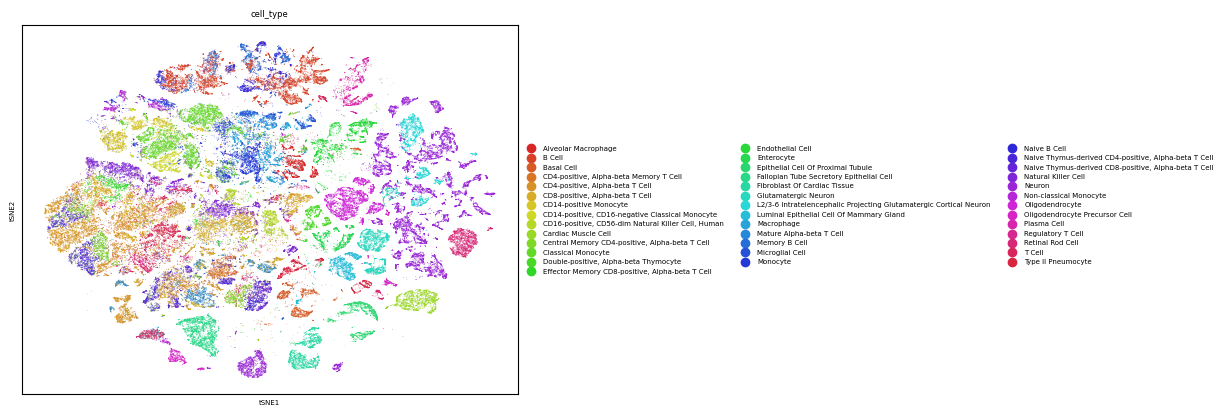

In [126]:
n = 40
cell_freq = adata_zero_shot.obs["cell_type"].value_counts()
adata_plot = adata_zero_shot[adata_zero_shot.obs["cell_type"].isin(cell_freq[:n].index.tolist())].copy()
# Plot t-SNE
sc.pl.tsne(
    adata_plot,
    color="cell_type",
    show=True,
    legend_fontoutline=1,
    palette=generate_colorblind_friendly_colors(n)
)

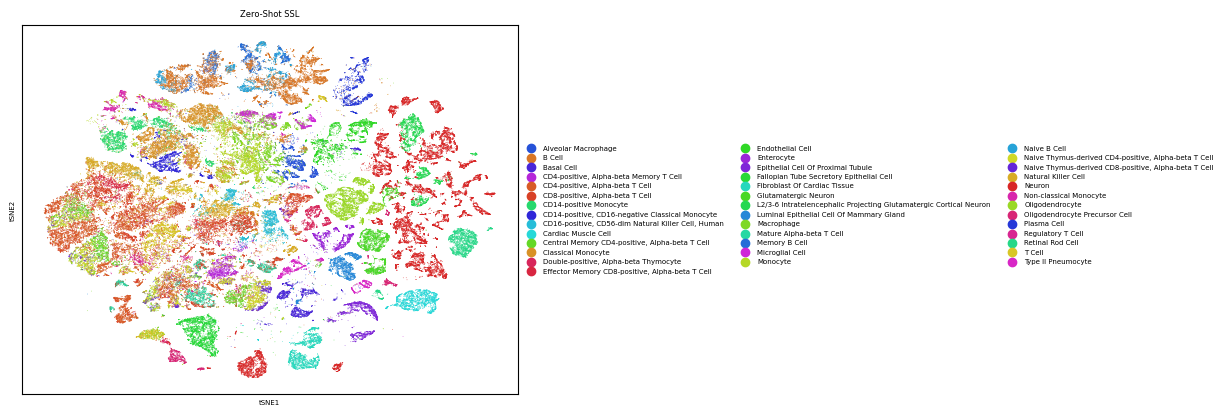

In [150]:
ax = plot_tsne(adata=adata_zero_shot, font_dict=font, cell_freq_thres=3000, save_dir='/lustre/groups/ml01/workspace/till.richter/ssl_results/classification/', size=1, title='Zero-Shot SSL')

### Supervised

In [ ]:
embeddings, labels = load_data(embedding_path='/lustre/groups/ml01/workspace/till.richter/ssl_results/classification/embeddings/test_emb_No_SSL_run0_No SSL.npy', labels=y_true_corrected)
adata = create_subsampled_adata(embeddings, labels, num_samples=200000)

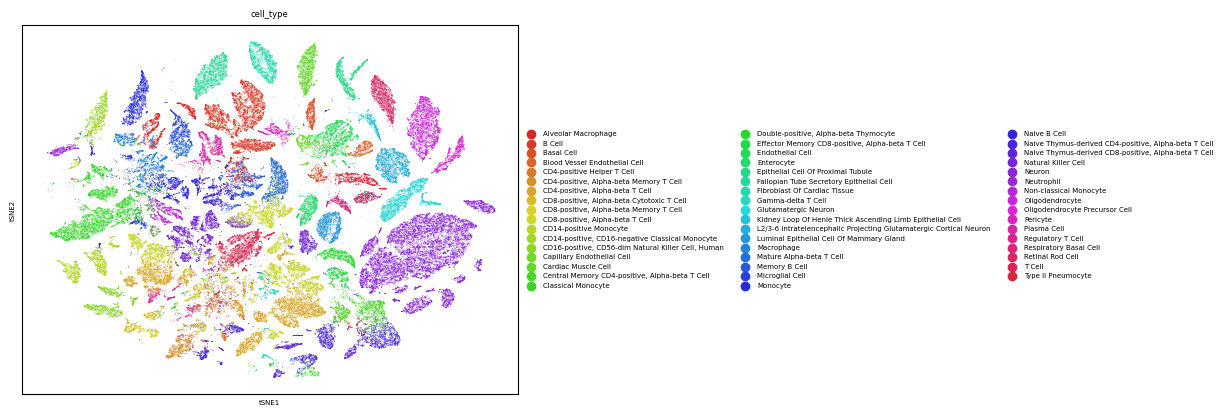

In [118]:
n = 50

adata_plot = adata[adata.obs["cell_type"].isin(cell_freq[:n].index.tolist())].copy()
# Plot t-SNE
sc.pl.tsne(
    adata_plot,
    color="cell_type",
    show=True,
    legend_fontoutline=1,
    palette=generate_colorblind_friendly_colors(n)
)

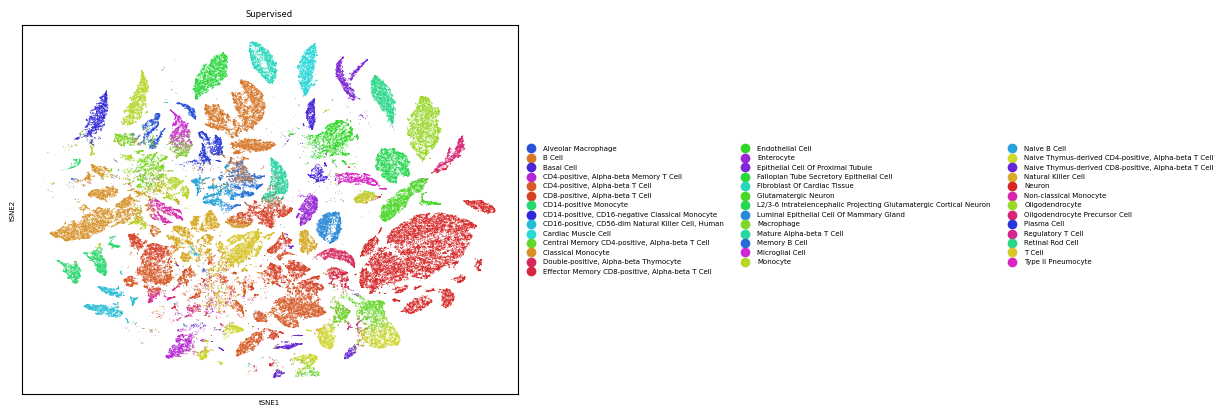

In [151]:
ax = plot_tsne(adata=adata, font_dict=font, cell_freq_thres=3000, save_dir='/lustre/groups/ml01/workspace/till.richter/ssl_results/classification/', size=1, title='Supervised')

### PCA

In [100]:
embeddings = np.load('/lustre/groups/ml01/workspace/till.richter/merlin_cxg_2023_05_15_sf-log1p/pca/x_pca_test_64.npy')
adata_pca = create_subsampled_adata(embeddings, y_true, num_samples=200000)

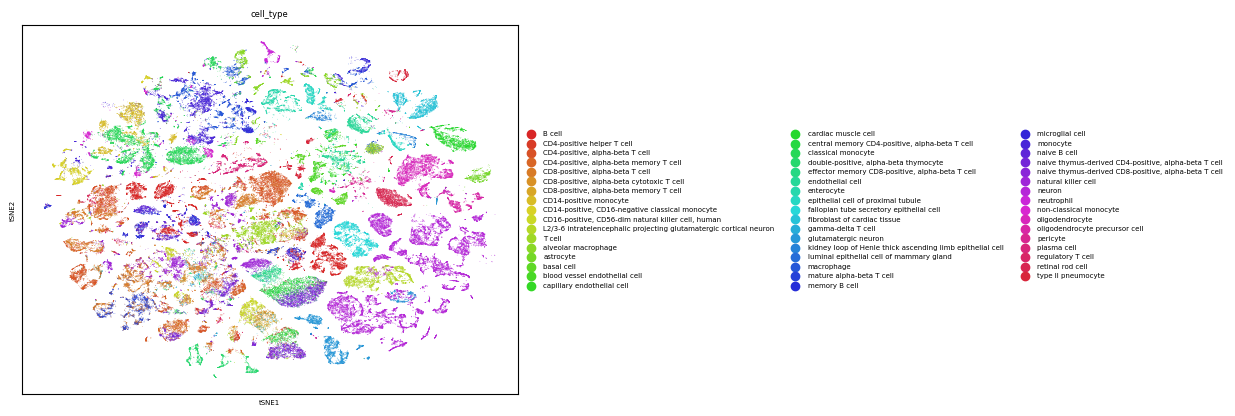

In [119]:
n = 50
cell_freq = adata_pca.obs["cell_type"].value_counts()
adata_plot = adata_pca[adata_pca.obs["cell_type"].isin(cell_freq[:n].index.tolist())].copy()
# Plot t-SNE
sc.pl.tsne(
    adata_plot,
    color="cell_type",
    show=True,
    legend_fontoutline=1,
    palette=generate_colorblind_friendly_colors(n)
)

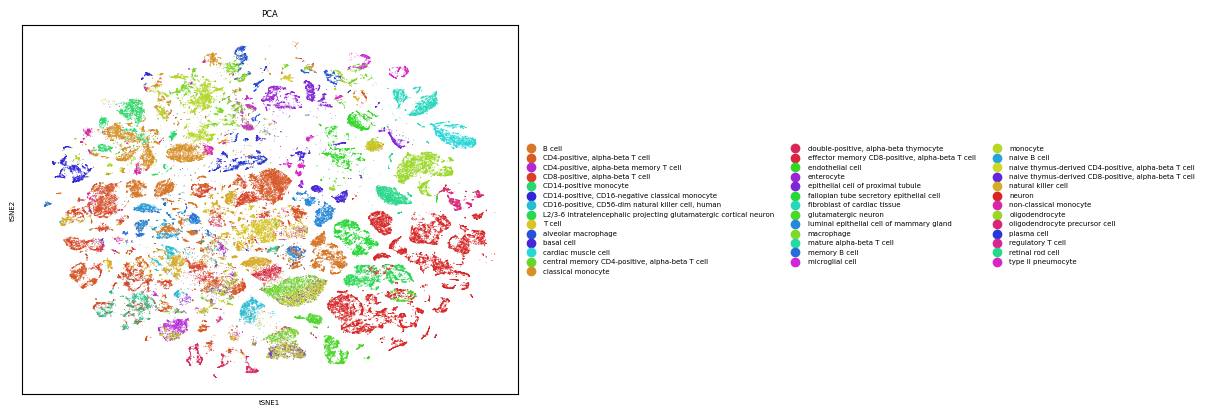

In [152]:
ax = plot_tsne(adata=adata_pca, font_dict=font, cell_freq_thres=3000, save_dir='/lustre/groups/ml01/workspace/till.richter/ssl_results/classification/', size=1, title='PCA')